In [80]:
import requests
from matplotlib import pyplot as plt
import os
import pickle
import pandas as pd
from ipyleaflet import Map, Polyline, Heatmap
from random import uniform
import threading
import math
import multiprocessing as mp
import numpy as np
import seaborn as srn

# Load Track Data

In [121]:
base_url = 'https://envirocar.org/api/stable/'

def get_tracks(k):
    tracks = []
    response = requests.get(base_url+'tracks?limit=100&page=%s' % str(k)).json()
    for track in response['tracks']:
        tracks.append(track)
    return tracks

def get_track_data(track):
    track_data = pd.read_csv(base_url + 'tracks/%s.csv' % track['id'], sep=';\s+', engine='python')
    track_data['track_id'] = track['id']
    try:
        track_data['length'] = track['length']
    except KeyError:
        track_data['length'] = None
    track_data['sensor_id'] = track['sensor']['properties']['id']
    return track_data

n = math.ceil(int(input('How many tracks to use: '))/100)*100
pool = mp.Pool(processes=int(n/100))
pages = pool.map(get_tracks, list(range(1, int(n/100)+1)))
pool.close()
pool.join()
tracks = []
for page in pages:
    tracks = tracks + page
pool = mp.Pool(processes=100)
mp.Pool(processes=100)
track_list = pool.map(get_track_data, tracks)
pool.close()
pool.join()
track_data = pd.concat(track_list)
print(track_data.shape)
sensors = track_data.sensor_id.unique()
sensor_names = []
for sensor in sensors:
    response = requests.get(base_url+'sensors/%s' % str(sensor)).json()
    sensor_names.append(response['properties']['manufacturer']+' '+response['properties']['model']+' ('+sensor+')')
track_data.head()

How many tracks to use: 1000
(412249, 28)


,CO2(kg/h),Calculated MAF(g/s),Consumption(l/h),Engine Load(%),GPS Accuracy(%),GPS Altitude(m),GPS Bearing(deg),GPS HDOP(precision),GPS PDOP(precision),GPS Speed(km/h),...,Rpm(u/min),Speed(km/h),Throttle Position(%),id,latitude,length,longitude,sensor_id,time,track_id
0,NaN,NaN,NaN,NaN,34.990974,53.009028,298.686477,1.700000,1.900000,10.761075,...,NaN,NaN,NaN,5ca961ad44ea8503022a45f1,-6.216738,1.08971,106.910470,5b028bb644ea8508c5b19991,2019-04-06T01:47:54Z,5ca961ad44ea8503022a45ef
1,NaN,NaN,NaN,NaN,35.052000,52.986999,315.666303,2.489621,2.689621,13.737492,...,NaN,NaN,NaN,5ca961ad44ea8503022a45f3,-6.216631,1.08971,106.910313,5b028bb644ea8508c5b19991,2019-04-06T01:47:58Z,5ca961ad44ea8503022a45ef
2,NaN,NaN,NaN,NaN,77.000000,44.000000,8.300000,1.800000,2.000000,10.548000,...,NaN,NaN,NaN,5ca961ad44ea8503022a45f4,-6.216066,1.08971,106.910335,5b028bb644ea8508c5b19991,2019-04-06T01:48:32Z,5ca961ad44ea8503022a45ef
3,NaN,NaN,NaN,NaN,47.979020,51.999999,27.434964,1.800000,2.000000,18.723775,...,NaN,NaN,NaN,5ca961ad44ea8503022a45f5,-6.215849,1.08971,106.910518,5b028bb644ea8508c5b19991,2019-04-06T01:48:39Z,5ca961ad44ea8503022a45ef
4,NaN,NaN,NaN,NaN,44.000000,54.053678,26.198608,1.800000,2.000000,16.110251,...,NaN,NaN,NaN,5ca961ad44ea8503022a45f6,-6.215696,1.08971,106.910570,5b028bb644ea8508c5b19991,2019-04-06T01:48:42Z,5ca961ad44ea8503022a45ef


# Plot all loaded tracks on map

In [122]:
m = Map(center = (track_data['latitude'].mean(), track_data['longitude'].mean()), zoom=3)
point_set = []
for track in tracks:
    df = track_data.loc[track_data['track_id'] == track['id']]
    points = list()
    for i in range(0, df.shape[0]):
        points.append([df.iloc[i]['latitude'], df.iloc[i]['longitude']])
    point_set.append(points)
line = Polyline(locations = [point_set], fill=False, opacity=0.5)
m.add_layer(line)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Plot single track on graph

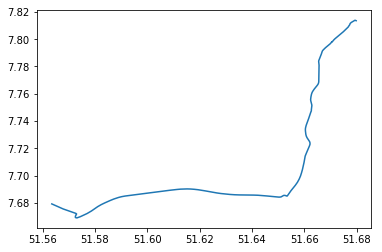

In [123]:
df = track_data.loc[track_data['track_id'] == tracks[1]['id']]
plt.plot(df['latitude'], df['longitude'])
FXREM2019040700002257 

# Plot all phenomenon for a single track

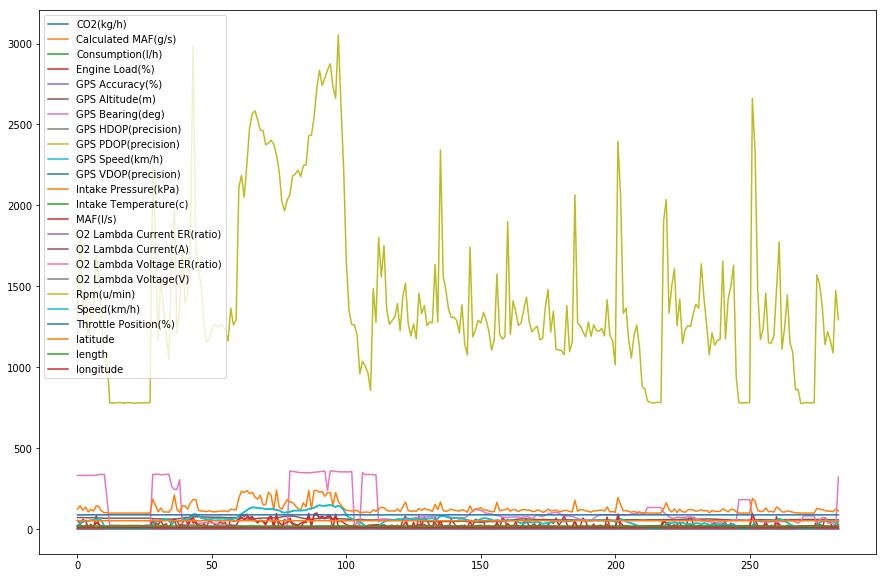

In [126]:
df.plot(figsize=(15, 10))

# Plot heatmap for all tracks w.r.t. speed

In [125]:
m = Map(center=(track_data['latitude'].mean(), track_data['longitude'].mean()), zoom=3)
point_set = []
for i in range(0, track_data.shape[0]):
    points = [track_data.iloc[i]['latitude'], track_data.iloc[i]['longitude'], track_data.iloc[i]['GPS Speed(km/h)']]
    point_set.append(points)
heatmap = Heatmap(locations=point_set,radius=5)
m.add_layer(heatmap);
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## A histogram showing the number of tracks vs length of the track

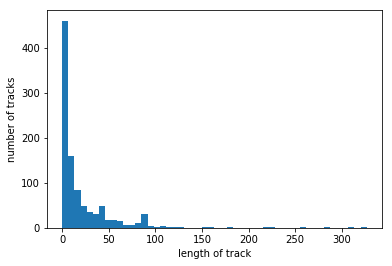

In [131]:
lengths = []
for track in tracks:
    try:
        lengths.append(track['length'])
    except KeyError:
        continue
plt.xlabel('length of track')
plt.ylabel('number of tracks')
_ = plt.hist(lengths, bins=50)

## Mean accuracies for all the sensors in the loaded data

1: Audi  A3 (5b028bb644ea8508c5b19991)
2: Volkswagen Golf VI (57418c7de4b09078f96fb94f)
3: Volvo V40 (564b916be4b0a3a81b856f28)
4: KIA Picanto (5c93d26a44ea8503020fd5ef)
5: KIA  Picanto (5c93d26244ea8503020fcb4e)
6: Citroën  C1 (5c932b3544ea850302a99dcf)
7: Toyota Yaris (5c86881b44ea8503025c13d4)
8: Toyota  Aygo (5c1db79644ea850302bc7d04)
9: Audi A6 RS 5 (5c22212c44ea850302bfa8de)
10: VW Golf VII (5c150bf044ea850302b14d29)
11: Nissan Altima (5bbe1e0a44ea850842fc8e88)
12: Mercedes Benz A 170 (559e22c2e4b07207d8977998)
13: Ford Fiesta (5bcb8b4b44ea850842072476)
14: Volkswagen  Golf V Variant (5661a3ebe4b000f94d376b5d)
15: vw Voyage (5ba54b5444ea850842645871)
16: toyota corolla (5ba5813344ea850842646096)
17: vw polo (5ba4fad844ea850842643031)
18: Toyota Innova (5b2f485d44ea8509105f4a61)
19: renault traffic (575fea15e4b0a69192b86975)
20: Opel Astra (57b4458be4b0f05fc13d10de)
21: Audi  A3 (5756e4f6e4b0a6919288479a)
22: Skoda Octavia Kombi (5b3e1b1344ea8509108ea245)
23: BMW X1 sDrive 16d (57

Text(0,0.5,'mean GPS accuracy(%)')

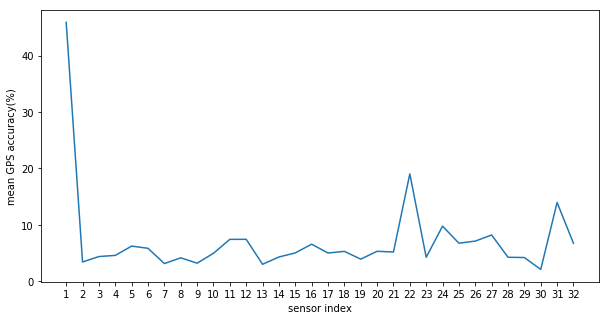

In [130]:
sensors = track_data.sensor_id.unique()
mean_accuracies = []
i = 1
for sensor in sensors:
    df = track_data.loc[track_data['sensor_id'] == sensor]
    mean_accuracies.append(df['GPS Accuracy(%)'].mean())
    print(str(i)+": "+sensor_names[i-1])
    i = i+1
plt.plot([str(i) for i in range(1, len(sensors)+1)], mean_accuracies, figure=plt.figure(figsize=(10,5)))
plt.xlabel('sensor index')
plt.ylabel('mean GPS accuracy(%)')

## Speed and altitude w.r.t. time

Text(0.5,0,'feature index')

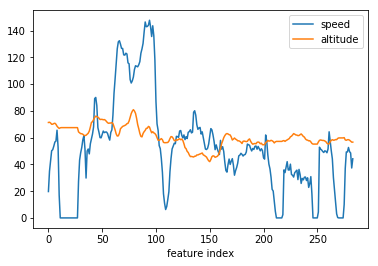

In [152]:
df = track_data.loc[track_data['track_id'] == tracks[1]['id']]
plt.plot(df['GPS Speed(km/h)'])
plt.plot(df['GPS Altitude(m)'])
plt.legend(['speed', 'altitude'])
plt.xlabel('feature index')